In [ ]:
#%cd
#shutil.rmtree('/content/hands_dataset', ignore_errors=True) #non usarloo

In [ ]:
%cd 
%cd ../content
!pwd

/root
/content
/content


In [ ]:
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

In [ ]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [ ]:

!pwd

!git clone https://github.com/tesiiscomingson/hands_dataset.git

/content
Cloning into 'hands_dataset'...
remote: Enumerating objects: 2696, done.
remote: Total 2696 (delta 0), reused 0 (delta 0), pack-reused 2696
Receiving objects: 100% (2696/2696), 22.06 MiB | 32.09 MiB/s, done.
Resolving deltas: 100% (863/863), done.


In [ ]:
%cd hands_dataset
!ls


/content/hands_dataset
Dataset  Examples  LICENSE  README.md


In [ ]:
!rm -rf Examples  LICENSE  README.md
!ls

Dataset


In [ ]:
dir_path = os.path.dirname(os.path.realpath('FT_mobilenet.ipynb'))
print(dir_path)

/content/hands_dataset


In [ ]:
!pwd

/content/hands_dataset


In [ ]:
%cd /content/hands_dataset/Dataset/
%mkdir train
%mkdir test
%mkdir valid
%mv 0/ 1/ 2 / 3/ 4/ 5/ 6/ 7/ 8/ 9/ train/

/content/hands_dataset/Dataset
mv: cannot move '/' to 'train': Device or resource busy


In [ ]:
#%cd -
!pwd
%cd valid
%mkdir 0/ 1/ 2 / 3/ 4/ 5/ 6/ 7/ 8/ 9/
%cd ../test
%mkdir 0/ 1/ 2 / 3/ 4/ 5/ 6/ 7/ 8/ 9/

/content/hands_dataset/Dataset
/content/hands_dataset/Dataset/valid
mkdir: cannot create directory ‘/’: File exists
/content/hands_dataset/Dataset/test
mkdir: cannot create directory ‘/’: File exists


In [ ]:

!pwd

/content/hands_dataset/Dataset/test


In [ ]:
%%bash
cd ../train
for ((i=0; i<=9; i++)); do
  a=$(find $i/ -type f | shuf -n 30)
  mv $a ../valid/$i/
  b=$(find $i/ -type f | shuf -n 5)
  mv $b ../test/$i/
done


In [ ]:
%cd ../..
!pwd

/content/hands_dataset
/content/hands_dataset


In [ ]:
train_path = 'Dataset/train'
valid_path = 'Dataset/valid'
test_path = 'Dataset/test'  

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path, target_size=(224, 224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path, target_size=(224, 224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 2172 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [ ]:
model = VGG16(include_top=True, weights='imagenet')

553467904/553467096 [==============================] - 3s 0us/step


In [ ]:
input_shape = model.layers[0].output_shape[0][1:3]

In [ ]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      brightness_range=[0.7,1.1],
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.2],
      horizontal_flip=False,
      vertical_flip=False,
      fill_mode='nearest')

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 20


We can save the randomly transformed images during training, so as to inspect whether they have been overly distorted, so we have to adjust the parameters for the data-generator above.

In [ ]:

if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

In [ ]:

generator_train = datagen_train.flow_from_directory(directory=train_path,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 2172 images belonging to 10 classes.


In [ ]:
generator_test = datagen_test.flow_from_directory(directory=valid_path,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 300 images belonging to 10 classes.


In [ ]:
steps_test = generator_test.n / batch_size
steps_test

15.0

In [ ]:
image_paths_train = path_join(train_path, generator_train.filenames)
image_paths_test = path_join(valid_path, generator_test.filenames)

In [ ]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [ ]:
class_names = list(generator_train.class_indices.keys())
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:

num_classes = generator_train.num_classes
num_classes

10

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
transfer_layer = model.get_layer('block5_pool')

In [ ]:
transfer_layer.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [ ]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
optimizer = Adam(lr=1e-5)

In [ ]:
loss = 'categorical_crossentropy'

In [ ]:
metrics = ['accuracy']

In [ ]:

def print_layer_trainable(mod):
    for layer in mod.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [ ]:
print_layer_trainable(conv_model)

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [ ]:
for layer in conv_model.layers:
    layer.trainable = False

In [ ]:

print_layer_trainable(model)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool
True:	flatten
True:	fc1
True:	fc2
True:	predictions


In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 40,416,074
Trainable params: 25,701,386
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:

epochs = 30
steps_per_epoch = 1700/20

In [ ]:
history = new_model.fit_generator(train_batches, steps_per_epoch=18,validation_data=valid_batches, validation_steps=3,epochs=60, verbose=2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
18/18 - 34s - loss: 2.6142 - accuracy: 0.1278 - val_loss: 2.1772 - val_accuracy: 0.3000
Epoch 2/60
18/18 - 1s - loss: 2.2524 - accuracy: 0.2722 - val_loss: 1.7951 - val_accuracy: 0.5000
Epoch 3/60
18/18 - 1s - loss: 2.0489 - accuracy: 0.2611 - val_loss: 1.6127 - val_accuracy: 0.5000
Epoch 4/60
18/18 - 1s - loss: 1.7414 - accuracy: 0.4222 - val_loss: 1.3553 - val_accuracy: 0.6333
Epoch 5/60
18/18 - 1s - loss: 1.7007 - accuracy: 0.4444 - val_loss: 1.3797 - val_accuracy: 0.7667
Epoch 6/60
18/18 - 1s - loss: 1.5533 - accuracy: 0.4833 - val_loss: 1.3156 - val_accuracy: 0.6667
Epoch 7/60
18/18 - 1s - loss: 1.1943 - accuracy: 0.6500 - val_loss: 0.9729 - val_accuracy: 0.8333
Epoch 8/60
18/18 - 1s - loss: 1.1970 - accuracy: 0.6667 - val_loss: 0.9321 - val_accuracy: 0.8000
Epoch 9/60
18/18 - 1s - loss: 1.1578 - accuracy: 0.6500 - val_loss: 1.0007 - val_accuracy: 0.7667
Epoch 10/60
18/18 - 1s - loss: 0.9552 - accuracy: 0.7556 - val_loss: 0.7718 - val_accuracy: 0.8667
Epoch 11/60
18/18 

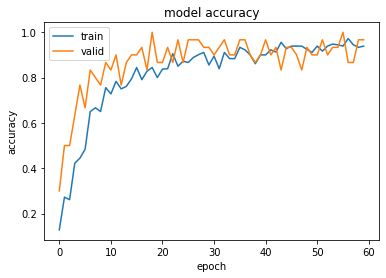

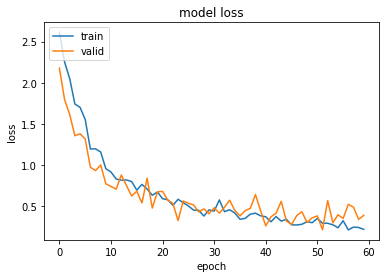

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_batches.classes
predictions = new_model.predict_generator(test_batches, steps=5, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 1 0]
 [0 0 0 4 1 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 4 1]
 [0 0 0 0 0 0 0 0 0 5]]


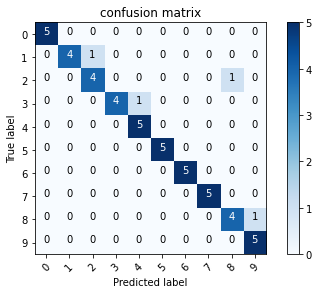

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')

In [ ]:
new_model.save('BD_VGG_model.h5')

predictions che dimensioni dovrebbe avere?? 50,10

In [ ]:
predictions.shape

(50, 10)

training con aug dataset dopo che ha già imparato dal dataset non aumentato, la validation è molto buona inizialmente poichè su di essa non agiscoin i filtri di augmentation.

Il training su Augmented dataset è molto lento. Perchè?

In [ ]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        verbose=2,
                        validation_data=generator_test,
                        validation_steps=steps_test)
                       

Epoch 1/30
85/85 - 34s - loss: 0.7143 - accuracy: 0.7819 - val_loss: 0.4370 - val_accuracy: 0.9067
Epoch 2/30
85/85 - 28s - loss: 0.6287 - accuracy: 0.8186 - val_loss: 0.4073 - val_accuracy: 0.9033
Epoch 3/30
85/85 - 29s - loss: 0.5932 - accuracy: 0.8316 - val_loss: 0.3889 - val_accuracy: 0.9033
Epoch 4/30
85/85 - 28s - loss: 0.5512 - accuracy: 0.8424 - val_loss: 0.3756 - val_accuracy: 0.9033
Epoch 5/30
85/85 - 28s - loss: 0.5077 - accuracy: 0.8599 - val_loss: 0.3527 - val_accuracy: 0.9033
Epoch 6/30
85/85 - 28s - loss: 0.4863 - accuracy: 0.8588 - val_loss: 0.3483 - val_accuracy: 0.9067
Epoch 7/30
85/85 - 28s - loss: 0.4583 - accuracy: 0.8741 - val_loss: 0.3357 - val_accuracy: 0.9033
Epoch 8/30
85/85 - 28s - loss: 0.4477 - accuracy: 0.8682 - val_loss: 0.3196 - val_accuracy: 0.9200
Epoch 9/30
85/85 - 28s - loss: 0.4282 - accuracy: 0.8747 - val_loss: 0.3287 - val_accuracy: 0.8967
Epoch 10/30
85/85 - 28s - loss: 0.4020 - accuracy: 0.8924 - val_loss: 0.2997 - val_accuracy: 0.9167
Epoch 11/

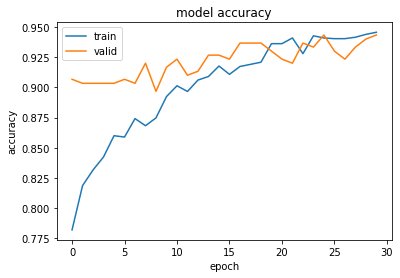

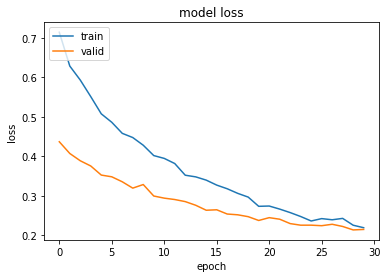

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
predictions = new_model.predict_generator(test_batches, steps=5, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 1 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 1 0 4 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


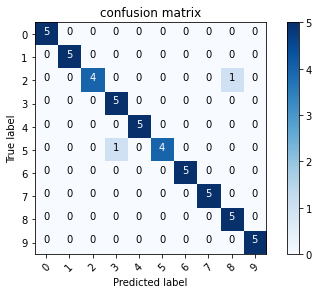

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')

In [ ]:
new_model.save('BD_AUG_VGG_model.h5')

Da test con webcam si trovano alcuni errori, allora procedo con un tuning dei due livelli superficiali del conv_model che non ho ancora trainato

In [ ]:
for layer in conv_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [ ]:
print_layer_trainable(model)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	flatten
True:	fc1
True:	fc2
True:	predictions


la learning rate è meglio se è minore del caso precedente in modo da evitare eccessive variazioni dovute all'errore dei layers aggiunti da me

In [ ]:
optimizer_fine = Adam(lr=1e-5)

In [ ]:
fine_model = new_model
fine_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

Oltra all'augmentation ci sono anche molti parametri da gestire

In [ ]:
history = fine_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        verbose=2,
                        validation_data=generator_test,
                        validation_steps=steps_test)

Epoch 1/30
85/85 - 29s - loss: 0.1594 - accuracy: 0.9504 - val_loss: 0.1296 - val_accuracy: 0.9633
Epoch 2/30
85/85 - 28s - loss: 0.1120 - accuracy: 0.9645 - val_loss: 0.0926 - val_accuracy: 0.9700
Epoch 3/30
85/85 - 28s - loss: 0.0759 - accuracy: 0.9818 - val_loss: 0.0935 - val_accuracy: 0.9667
Epoch 4/30
85/85 - 28s - loss: 0.0760 - accuracy: 0.9787 - val_loss: 0.0886 - val_accuracy: 0.9867
Epoch 5/30
85/85 - 28s - loss: 0.0433 - accuracy: 0.9852 - val_loss: 0.0930 - val_accuracy: 0.9733
Epoch 6/30
85/85 - 28s - loss: 0.0742 - accuracy: 0.9776 - val_loss: 0.0873 - val_accuracy: 0.9867
Epoch 7/30
85/85 - 28s - loss: 0.0379 - accuracy: 0.9894 - val_loss: 0.0898 - val_accuracy: 0.9800
Epoch 8/30
85/85 - 28s - loss: 0.0388 - accuracy: 0.9894 - val_loss: 0.0812 - val_accuracy: 0.9867
Epoch 9/30
85/85 - 28s - loss: 0.0495 - accuracy: 0.9846 - val_loss: 0.0752 - val_accuracy: 0.9800
Epoch 10/30
85/85 - 28s - loss: 0.0330 - accuracy: 0.9918 - val_loss: 0.0843 - val_accuracy: 0.9833
Epoch 11/

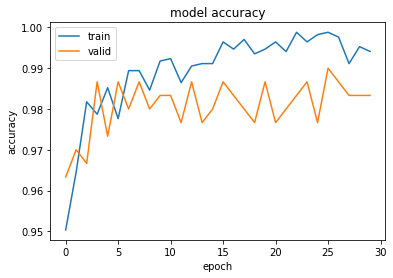

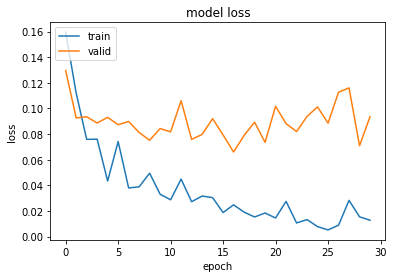

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
fine_predictions = fine_model.predict_generator(test_batches, steps=5, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
cm = confusion_matrix(test_labels, fine_predictions.argmax(axis=1))

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


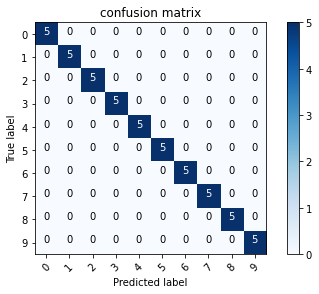

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')

In [ ]:
fine_model.save('BDVGG16_AUGdeeper_training.h5')